In [1]:
from copy import deepcopy

import torch
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

from hysteresis.base import TorchHysteresis
from hysteresis.hybrid import HybridGP
from torchAccelerator.first_order import TorchDrift
from torchAccelerator.hysteresis import HysteresisAccelerator, HysteresisQuad
import matplotlib.pyplot as plt

def density_function(mesh_pts):
    x = mesh_pts[:, 0]
    y = mesh_pts[:, 1]
    return torch.exp(-(y - x) / 0.5)


def beamsize(accel_model, R_i):
    return accel_model.forward(R_i)[0, 0]

def get_iterative_min(loss):
    result = torch.empty(len(loss))
    for i in range(1, len(loss)):
        result[i] = torch.min(loss[:i])
    return result

#def total_beamsize(R):
#    return torch.sqrt(R[0, 0] + R[2, 2])

def objective(R):
    return (torch.sqrt(R[0,0]) - 2.0e-3)**2 + (torch.sqrt(R[2,2]) - 2.0e-3)**2

In [2]:
from gpytorch.utils.errors import NotPSDError
from botorch import fit_gpytorch_model
from gpytorch import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from tqdm.notebook import trange
import time


def optimize(accelerator_model,
             initial_beam_matrix,
             h_models,
             steps = 50,
             apply_fields=True,
             use_hybrid_model=True):

    iterations = steps


    # initialize with a couple of points
    train_X = torch.ones((3, 3))*0.75
    train_X[0] = train_X[0]*0.0
    train_X[2] = train_X[2]*-1.0
    train_Y = torch.empty((3,1))

    for j in range(3):
        accelerator_model.q1.fantasy_H.data = train_X[j][0]
        accelerator_model.q2.fantasy_H.data = train_X[j][1]
        accelerator_model.q3.fantasy_H.data = train_X[j][2]

        train_Y[j] = objective(
            accelerator_model.forward(initial_beam_matrix)
        )

        if apply_fields:
            #print(f"applying field {train_X[j]}")
            accelerator_model.apply_fields({"q1": train_X[j][0],
                                            "q2": train_X[j][1],
                                            "q3": train_X[j][2]})
    print(train_Y.clone())

    for i in trange(iterations):
        if use_hybrid_model:
            #train hybrid GP model
            gpmodel = HybridGP(train_X.detach(), train_Y.detach(), h_models)
        else:
            std_trans = Standardize(1)
            gpmodel = SingleTaskGP(train_X,
                                   train_Y.detach(),
                                   outcome_transform=std_trans)
            mll = ExactMarginalLogLikelihood(gpmodel.likelihood, gpmodel)

            try:
                fit_gpytorch_model(mll)
            except NotPSDError:
                print('Handling NotPSDError')
                mll.load_state_dict(hypers)

            # save hyper params
            hypers = mll.state_dict()


        UCB = UpperConfidenceBound(gpmodel, beta=2.1, maximize=False)

        bounds = torch.stack([-1.0 * torch.ones(3), torch.ones(3)])
        candidate, acq_value = optimize_acqf(
            UCB,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=20,
        )
        train_X = torch.cat((train_X, candidate))
        accelerator_model.q1.fantasy_H.data = candidate[0][0]
        accelerator_model.q2.fantasy_H.data = candidate[0][1]
        accelerator_model.q3.fantasy_H.data = candidate[0][2]

        # make next measurement
        bs = objective(
            accelerator_model.forward(initial_beam_matrix)
        ).reshape(1, 1)
        train_Y = torch.cat((train_Y.clone(), bs.clone()))

        if apply_fields:
            #print(f"applying field {train_X[-1]}")
            accelerator_model.apply_fields({"q1": train_X[-1][0],
                                            "q2": train_X[-1][1],
                                            "q3": train_X[-1][2]})

    return train_X, train_Y, accelerator_model

tensor(0.2501, dtype=torch.float64)


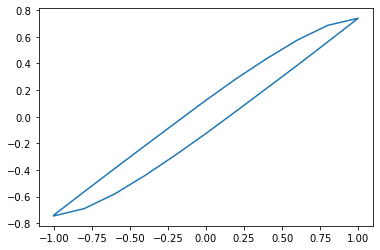

In [3]:
# hysteresis model
H = TorchHysteresis(mesh_scale=0.1, trainable=False)
dens = density_function(H.mesh_points)
H.h_min = -1.0
H.hysterion_density = dens

test_H = deepcopy(H)
test_applied_fields = torch.cat(
    (torch.linspace(-1,1,11) , torch.flipud(torch.linspace(-1,1,11)))
)
test_H.applied_fields = test_applied_fields
with torch.no_grad():
    M = test_H.predict_magnetization()

fig,ax = plt.subplots()
ax.plot(test_applied_fields, M)

diff = (M[16] - M[5])
print(diff)


In [4]:
# accelerator model
hmodels = [deepcopy(H)] * 3

# define quadrupoles
d0 = TorchDrift("d0", torch.tensor(1.0))
q1 = HysteresisQuad("q1", torch.tensor(0.1), hmodels[0], scale=torch.tensor(10.0))
d1 = TorchDrift("d1", torch.tensor(1.0))
d2 = TorchDrift("d2", torch.tensor(1.0))
q2 = HysteresisQuad("q2", torch.tensor(0.1), hmodels[1], scale=torch.tensor(10.0))
d3 = TorchDrift("d3", torch.tensor(1.5))
q3 = HysteresisQuad("q3", torch.tensor(0.1), hmodels[2], scale=torch.tensor(10.0))

HA = HysteresisAccelerator([d0, q1, d1, q2, d2, q3, d3])

for name, val in HA.named_parameters():
    if val.requires_grad:
        print(f"{name}:{val}")

init_beam_matrix = torch.eye(6) * 1.0e-8

#set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
init_beam_matrix[0,0] = 1.0e-3 ** 2
init_beam_matrix[1,1] = 1.0e-4 ** 2
init_beam_matrix[2,2] = 1.0e-3 ** 2
init_beam_matrix[3,3] = 1.0e-4 ** 2
R = init_beam_matrix


X = []
Y = []
all_models = []
for ele in [False, True]:
    trace_x = []
    trace_y = []
    models = []
    for k in range(5):
        print(k)
        p, l, model = optimize(deepcopy(HA),
                               R,
                               hmodels,
                               apply_fields=True,
                               steps=50,
                               use_hybrid_model=ele)
        trace_x += [p.clone()]
        trace_y += [l.squeeze().detach().clone()]
        models += [deepcopy(model)]

    X += [torch.vstack([ele.unsqueeze(0) for ele in trace_x])]
    Y += [torch.vstack([ele.unsqueeze(0) for ele in trace_y])]
    all_models += [models]

X = torch.cat([ele.unsqueeze(0) for ele in X])
Y = torch.cat([ele.unsqueeze(0) for ele in Y])


q1.fantasy_H:Parameter containing:
tensor([-1.], requires_grad=True)
q2.fantasy_H:Parameter containing:
tensor([-1.], requires_grad=True)
q3.fantasy_H:Parameter containing:
tensor([-1.], requires_grad=True)
0
tensor([[2.8350e-06],
        [3.3848e-05],
        [3.4914e-05]], grad_fn=<CloneBackward>)


  0%|          | 0/50 [00:00<?, ?it/s]

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

1
tensor([[2.8350e-06],
        [3.3848e-05],
        [3.4914e-05]], grad_fn=<CloneBackward>)


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

2
tensor([[2.8350e-06],
        [3.3848e-05],
        [3.4914e-05]], grad_fn=<CloneBackward>)


  0%|          | 0/50 [00:00<?, ?it/s]

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

3
tensor([[2.8350e-06],
        [3.3848e-05],
        [3.4914e-05]], grad_fn=<CloneBackward>)


  0%|          | 0/50 [00:00<?, ?it/s]

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

4
tensor([[2.8350e-06],
        [3.3848e-05],
        [3.4914e-05]], grad_fn=<CloneBackward>)


  0%|          | 0/50 [00:00<?, ?it/s]

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

0
tensor([[2.8350e-06],
        [3.3848e-05],
        [3.4914e-05]], grad_fn=<CloneBackward>)


  0%|          | 0/50 [00:00<?, ?it/s]

1
tensor([[2.8350e-06],
        [3.3848e-05],
        [3.4914e-05]], grad_fn=<CloneBackward>)


  0%|          | 0/50 [00:00<?, ?it/s]

2
tensor([[2.8350e-06],
        [3.3848e-05],
        [3.4914e-05]], grad_fn=<CloneBackward>)


  0%|          | 0/50 [00:00<?, ?it/s]

3
tensor([[2.8350e-06],
        [3.3848e-05],
        [3.4914e-05]], grad_fn=<CloneBackward>)


  0%|          | 0/50 [00:00<?, ?it/s]

4
tensor([[2.8350e-06],
        [3.3848e-05],
        [3.4914e-05]], grad_fn=<CloneBackward>)


  0%|          | 0/50 [00:00<?, ?it/s]

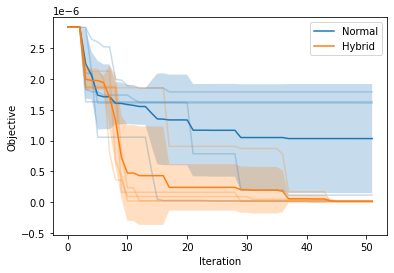

In [5]:
fig2, ax2 = plt.subplots()

c = ['C0','C1']
labels = ['Normal','Hybrid']

def get_best(input):
    result = torch.empty((len(input), len(input[0])-1))
    for ii in range(len(input)):
        for jj in range(1, len(input[0])):
            result[ii][jj-1] = torch.min(input[ii][:jj])
    return result


for idx, ele in enumerate(Y):
    best = get_best(ele)
    mean = torch.mean(best, dim=0)
    std = torch.std(best, dim=0)
    ax2.plot(mean, c[idx], label=labels[idx])
    ax2.fill_between(range(len(std)), mean-std, mean+std, fc=c[idx], alpha=0.25)

    for k in best:
        ax2.plot(k,c=c[idx],alpha=0.25)

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective')
ax2.legend()

torch.Size([8, 6, 6])


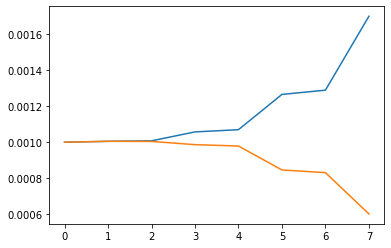

In [14]:
# plot accelerator model
best_model = all_models[0][4]
beam_matrix = best_model.forward(init_beam_matrix, full=False, current=True)
print(beam_matrix.shape)

fig,ax = plt.subplots()
ax.plot(torch.sqrt(beam_matrix[:, 0, 0]).detach())
ax.plot(torch.sqrt(beam_matrix[:, 2, 2]).detach())

#fig2.savefig('normal_vs_hybrid.png')


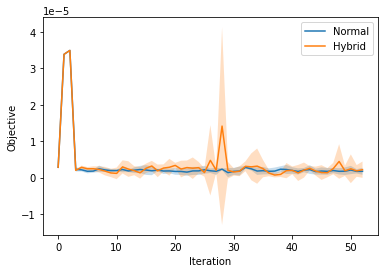

In [7]:
fig2, ax2 = plt.subplots()

c = ['C0','C1']
labels = ['Normal','Hybrid']

for idx, ele in enumerate(Y):
    mean = torch.mean(ele, dim=0)
    std = torch.std(ele, dim=0)
    ax2.plot(mean, c[idx], label=labels[idx])
    ax2.fill_between(range(len(std)), mean-std, mean+std, fc=c[idx], alpha=0.25)

    #for k in ele:
    #    ax2.plot(k,c=c[idx],alpha=0.25)

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective')
ax2.legend()


In [8]:
print(Y)
idx = torch.argmin(Y[0][0])
print(idx)
print(X[0][0][idx])
print(Y[0][0][idx])

tensor([[[2.8350e-06, 3.3848e-05, 3.4914e-05, 2.0889e-06, 2.5404e-06,
          1.0539e-06, 1.3303e-06, 1.2014e-06, 1.5188e-06, 1.1163e-06,
          1.5599e-06, 1.6750e-06, 1.6316e-06, 1.4492e-06, 5.3015e-07,
          5.0137e-08, 2.8051e-08, 2.3011e-06, 4.2176e-07, 7.5409e-07,
          1.6488e-07, 5.8879e-07, 4.9832e-08, 5.6247e-07, 1.9537e-08,
          2.2588e-07, 1.5063e-06, 5.0229e-08, 2.4746e-06, 5.6654e-08,
          1.2689e-06, 5.7825e-07, 2.4840e-06, 2.7603e-06, 4.2078e-08,
          1.6260e-06, 1.3780e-06, 2.5269e-06, 2.4862e-06, 1.7983e-07,
          7.9480e-07, 2.5012e-07, 1.2261e-06, 1.3504e-07, 1.6152e-06,
          1.3082e-06, 1.9419e-07, 7.4096e-07, 2.1919e-07, 3.6340e-07,
          1.1785e-07, 1.5861e-06, 2.1609e-08],
         [2.8350e-06, 3.3848e-05, 3.4914e-05, 1.6276e-06, 1.6303e-06,
          1.6291e-06, 1.6868e-06, 2.1726e-06, 1.9917e-06, 1.9413e-06,
          2.0590e-06, 3.0094e-06, 2.3601e-06, 1.9222e-06, 2.6057e-06,
          2.3075e-06, 1.8208e-06, 2.5024e-0